In [100]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr 
import matplotlib.pyplot as plt
from shapely.geometry import Point

import global_gauges as gg

target_crs = "ESRI:102004"

datasets = Path("/nas/cee-water/cjgleason/data")
proj_root = Path("/nas/cee-water/cjgleason/ted/swot-ml")

data_dir = proj_root / 'data' / 'distributed' 
metadata_dir = data_dir / 'metadata'
metadata_dir.mkdir(parents=True, exist_ok=True)

fig_dir = data_dir / '_figures'
fig_dir.mkdir(parents=True, exist_ok=True)

basin = 'Ohio'
# basin = 'Upper_Miss'
# basin = 'Missouri'

<Axes: >

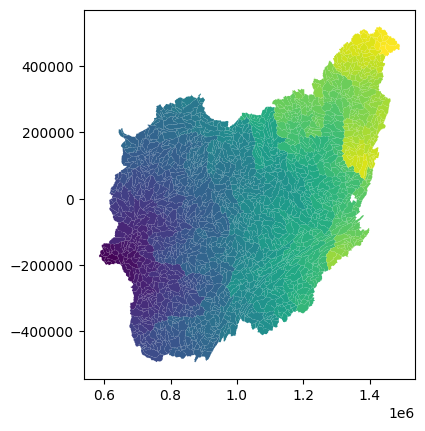

In [101]:
basins = gpd.read_file(metadata_dir / f'{basin}_basins.geojson').to_crs(target_crs)
basins = basins.rename(columns={'UP_AREA':'hybas_area'})

basin_geom = basins.geometry.union_all()
basins.plot('graph_distance')

0       6.140933e+06
1       2.851866e+07
2       1.351627e+08
3       2.230552e+08
4       1.215636e+08
            ...     
1957    2.497953e+08
1958    6.375211e+08
1959    2.099551e+08
1960    7.814291e+08
1961    5.704458e+08
Length: 1962, dtype: float64

In [102]:
facade = gg.GaugeDataFacade(providers='usgs')
sites = facade.get_stations_n_days(90).to_crs(target_crs)

basin_sites = sites.clip(basin_geom).copy()
basin_sites.drop('provider_misc', axis=1, inplace=True) # all na column is problematic

In [116]:
outlets.geometry.x

0     -86.956111
1     -86.306364
2     -86.446655
3     -87.700585
4     -87.579022
         ...    
343   -78.386129
344   -78.450861
345   -78.715556
346   -79.133101
347   -79.203639
Length: 348, dtype: float64

In [143]:
outlets = basin_sites[basin_sites['mean_discharge']>10].reset_index()
outlets = outlets.to_crs('epsg:4326')
outlets['lng'] = outlets.geometry.x
outlets['lat'] = outlets.geometry.y
outlets.rename(columns={'site_id':'id'}, inplace=True)

outlets['outlet_id'] = outlets.iloc[outlets['area'].argmax()]['id']

outlets = outlets[['id','lng','lat','name','outlet_id']]
outlets.to_csv('/nas/cee-water/cjgleason/ted/delineator/ohio_full.csv', index=False)

<Axes: >

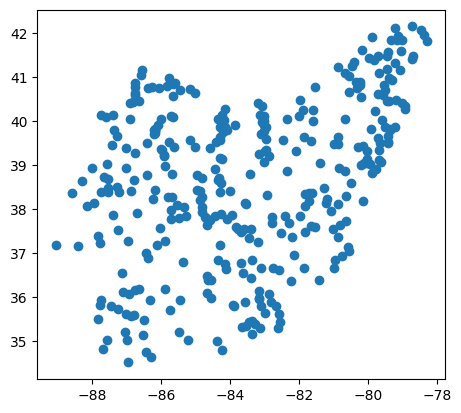

In [142]:
outlets.plot()

In [6]:
print("reading SWORD")
sword_dir =  datasets / 'SWORD' / 'SWORDv17' / 'shp'
sword_files = list(sword_dir.glob('*/*reaches*.shp'))
sword = pd.concat([gpd.read_file(f) for f in tqdm(sword_files)])

sword = sword.to_crs(target_crs).clip(basin_geom)
sword['type'] = sword['reach_id']%10
sword = sword.rename(columns={'facc':'sword_area'})

# Get subset of rivers and lakes on rivers
basin_sword = sword[sword['type'].isin([1,3])]

reading SWORD


100%|██████████| 60/60 [00:21<00:00,  2.85it/s]


<Axes: >

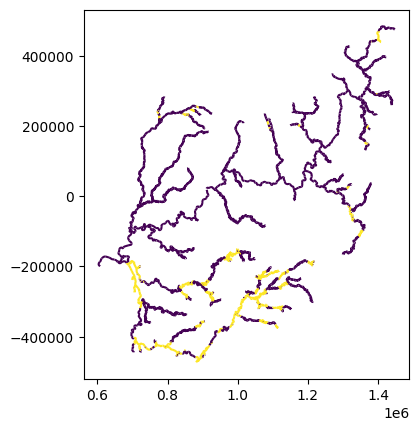

In [17]:
basin_sword.plot('type')

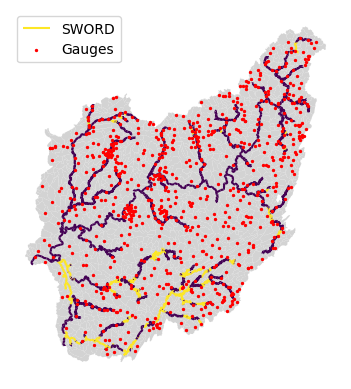

In [7]:
fig, ax = plt.subplots()
plt.axis('off')
# plt.style.use('dark_background')

basins.plot(color='lightgrey', ax=ax)
basin_sword.plot('type', ax=ax, linewidth=1.5, label="SWORD")
basin_sites.plot(ax=ax, color='red', markersize=2, zorder=10, label="Gauges")
plt.legend()

fig.savefig(fig_dir / f'All_data_{basin}.png', dpi=300)

In [14]:
basin_sword[basin_sword['type']==3]

KeyError: 'name'

In [8]:
matchups = basins[['HYBAS_ID','hybas_area','graph_distance','geometry']]

matchups = gpd.sjoin_nearest(
    matchups, 
    basin_sites,
    how='left',
    max_distance=1000,
    distance_col='hybas_distance')

matchups = gpd.sjoin_nearest(
    matchups,
    basin_sword[['reach_id', 'type', 'sword_area', 'geometry']],
    how='left',
    max_distance=1000,
    distance_col='sword_distance')
matchups.drop(columns='index_right', inplace=True)

matchups = matchups.to_crs('epsg:4326').reset_index(drop=True)

In [9]:
sword_pfaf2 = (matchups['reach_id'] // 1E9).dropna().unique()

if len(sword_pfaf2) != 1:
    print("Not implemented for multiple Pfaf2 basins at a time.")
else:
    ms_path = datasets/"MERIT-SWORD"/"ms_translate"/"sword_to_mb"
    mb_ds = xr.open_dataset(ms_path / f"sword_to_mb_pfaf_{int(sword_pfaf2[0])}_translate.nc")

    # Load in PLD data
    stem = f"SWOT_L2_HR_LakeAvg_024_NA_{int(sword_pfaf2[0])}_20241112T025038_20241202T233543_PIC2_01.shp"
    filepath = datasets / 'PLD' / 'SWOT_L2_HR_LAKEAVG' / stem
    pld = gpd.read_file(filepath).replace({'no_data': None}).dropna(subset='reach_id')

    pld['reach_id'] = pld["reach_id"].apply(
        lambda x: x.split(";") if isinstance(x, str) and x.strip() else []
    )
    pld = pld.explode('reach_id')
    

In [10]:
grp_cols = ['hybas_area', 'geometry']
site_cols = ['site_id','name','area','latitude','longitude','min_date','max_date','min_discharge','max_discharge','mean_discharge','count_discharge','provider']
sword_r_cols = ['reach_id','sword_area','sword_distance']
sword_l_cols = ['lake_reach_ids', 'lake_pld_ids']
all_columns = grp_cols + site_cols + sword_r_cols + sword_l_cols


mb_vars = [var for var in mb_ds.data_vars if var.startswith("mb_")]

def get_best_pair(grp):
    data_dict = {k: np.nan for k in all_columns}
    data_dict.update(grp.iloc[0][grp_cols].to_dict())

    # SWORD river reach matching.
    # Pick best match by area with a limit of 30% difference.
    rivers = grp[grp['type']==1]
    if len(rivers)>0:
        sword_area_diff = (grp['sword_area'] - grp['hybas_area']) / (grp[['sword_area','hybas_area']].mean(axis=1))
        if any(sword_area_diff.abs() < 0.3):
            idx_min = sword_area_diff.abs().idxmin()
            data_dict.update(grp.loc[idx_min][sword_r_cols].to_dict())

    # Get all SWORD lake reaches in the subbasin
    sword_lakes = grp[grp['type']==3]
    sword_lake_ids =  sword_lakes['reach_id'].astype(int).to_list()
    data_dict['lake_reach_ids'] = sword_lake_ids

    pld_ix = pld[pld['reach_id'].astype(int).isin(sword_lake_ids)]
    pld_ids = pld_ix['lake_id'].astype(int).to_list()
    data_dict['lake_pld_ids'] = list(set(pld_ids))
    
    # Gauge site matching.
    # Pick best match by area with limit of 30% difference.
    site_area_diff = (grp['area'] - grp['hybas_area']) / (grp[['area','hybas_area']].mean(axis=1))
    if any(site_area_diff.abs() < 0.3):
        idx_min = site_area_diff.abs().idxmin()
        data_dict.update(grp.loc[idx_min][site_cols].to_dict())

    # Get all MERIT basin ids corresponding to SWORD reaches
    sword_ids = grp['reach_id'].dropna().astype(int).unique()
    mb_vals = []
    for sid in sword_ids:
        if sid in mb_ds['sword']:
            mbvs = [mb_ds[var].sel(sword=sid).item() for var in mb_vars]
            mbvs = [mb for mb in mbvs if mb != 0] # trim 0s 
            mb_vals.extend(mbvs)
    data_dict['mb_values'] = mb_vals 

    return pd.Series(data_dict)
        
matchups_clean = matchups.groupby('HYBAS_ID').apply(get_best_pair, include_groups=False)
matchups_clean.set_crs('epsg:4326', inplace=True)

,hybas_area,geometry,site_id,name,area,latitude,longitude,min_date,max_date,min_discharge,max_discharge,mean_discharge,count_discharge,provider,reach_id,sword_area,sword_distance,lake_reach_ids,lake_pld_ids,mb_values
HYBAS_ID,,,,,,,,,,,,,,,,,,,,
7090343370,198.7,"POLYGON ((-93.23333 47.55833, -93.23975 47.558...",NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[]
7090343450,136.2,"POLYGON ((-93.23333 47.55417, -93.23333 47.558...",NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[]
7090343790,148.0,"POLYGON ((-93.4375 47.70417, -93.43333 47.7041...",NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[]
7090343800,370.5,"POLYGON ((-93.22083 47.52917, -93.23138 47.529...",NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[]
7090345360,103.3,"POLYGON ((-93.45833 47.60417, -93.45612 47.603...",NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7091053920,385.6,"POLYGON ((-89.23333 41.7375, -89.2375 41.7375,...",NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[]
7091054370,514.7,"POLYGON ((-89.25 41.64167, -89.25242 41.64202,...",NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[]
7091054810,656.9,"POLYGON ((-89.47083 41.6625, -89.47119 41.6690...",NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[]


In [11]:
import itertools
lake_ids = list(itertools.chain.from_iterable(matchups_clean['lake_reach_ids']))
basin_sword_l_clean = basin_sword[basin_sword['reach_id'].isin(lake_ids)]

basin_sword_r_clean = basin_sword[basin_sword['reach_id'].isin(matchups_clean['reach_id'])]
basin_sites_clean = basin_sites[basin_sites.index.isin(matchups_clean['site_id'])]

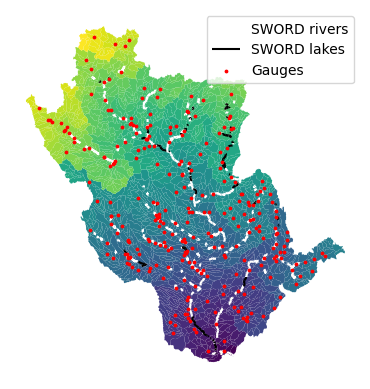

In [12]:
fig, ax = plt.subplots()
plt.axis('off')
plt.style.use('default')

basins.plot('graph_distance', ax=ax, zorder=0)
basin_sword_r_clean.plot(ax=ax, color='white', linewidth=1.5, zorder=9, label="SWORD rivers")
basin_sword_l_clean.plot(ax=ax, color='black', linewidth=1.5, zorder=9, label="SWORD lakes")
basin_sites_clean.plot(ax=ax, color='red', markersize=3, zorder=10, label="Gauges")
plt.legend()

fig.savefig(fig_dir / f'matchups_{basin}.png', dpi=300)

In [13]:
matchups_clean.to_file(metadata_dir / f'{basin}_matchups.geojson', driver='GeoJSON')
print(sum(~matchups_clean['reach_id'].isna()))

347


In [14]:
test = gpd.read_file(metadata_dir / f'{basin}_matchups.geojson')
test

,HYBAS_ID,hybas_area,site_id,name,area,latitude,longitude,min_date,max_date,min_discharge,...,mean_discharge,count_discharge,provider,reach_id,sword_area,sword_distance,lake_reach_ids,lake_pld_ids,mb_values,geometry
0,7090343370,198.7,None,None,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,None,NaN,NaN,NaN,[ ],[ ],[ ],"POLYGON ((-93.23333 47.55833, -93.23975 47.558..."
1,7090343450,136.2,None,None,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,None,NaN,NaN,NaN,[ ],[ ],[ ],"POLYGON ((-93.23333 47.55417, -93.23333 47.558..."
2,7090343790,148.0,None,None,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,None,NaN,NaN,NaN,[ ],[ ],[ ],"POLYGON ((-93.4375 47.70417, -93.43333 47.7041..."
3,7090343800,370.5,None,None,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,None,NaN,NaN,NaN,[ ],[ ],[ ],"POLYGON ((-93.22083 47.52917, -93.23138 47.529..."
4,7090345360,103.3,None,None,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,None,NaN,NaN,NaN,[ ],[ ],[ ],"POLYGON ((-93.45833 47.60417, -93.45612 47.603..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1707,7091053920,385.6,None,None,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,None,NaN,NaN,NaN,[ ],[ ],[ ],"POLYGON ((-89.23333 41.7375, -89.2375 41.7375,..."
1708,7091054370,514.7,None,None,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,None,NaN,NaN,NaN,[ ],[ ],[ ],"POLYGON ((-89.25 41.64167, -89.25242 41.64202,..."
1709,7091054810,656.9,None,None,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,None,NaN,NaN,NaN,[ ],[ ],[ ],"POLYGON ((-89.47083 41.6625, -89.47119 41.6690..."
1710,7091055400,783.1,None,None,NaN,NaN,NaN,NaT,NaT,NaN,...,NaN,NaN,None,NaN,NaN,NaN,[ ],[ ],[ ],"POLYGON ((-89.58333 41.60833, -89.5875 41.6083..."


In [ ]:
test.plot()